In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, nsd_utils

In [2]:
# Load results of the fitting procedure
subjects = np.arange(1,9)
# subjects = [1]
n_subjects = len(subjects)

semantic_discrim_type = 'all_coco_categ_pca'
fitting_type = 'full_midlevel_plus_%s'%semantic_discrim_type
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False) \
       for ss in subjects]

fitting_type1 = 'full_midlevel'
out_midlevel = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type1, \
                                  n_from_end=0, verbose=False) \
       for ss in subjects]

fitting_type2 = 'all_coco_categ_pca'
out_coco = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, \
                                  n_from_end=0, verbose=False) \
       for ss in subjects]

fig_save_folder=None

# initialize roi_def objects to get roi indices
roi_def = roi_utils.multi_subject_roi_def(subjects)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois


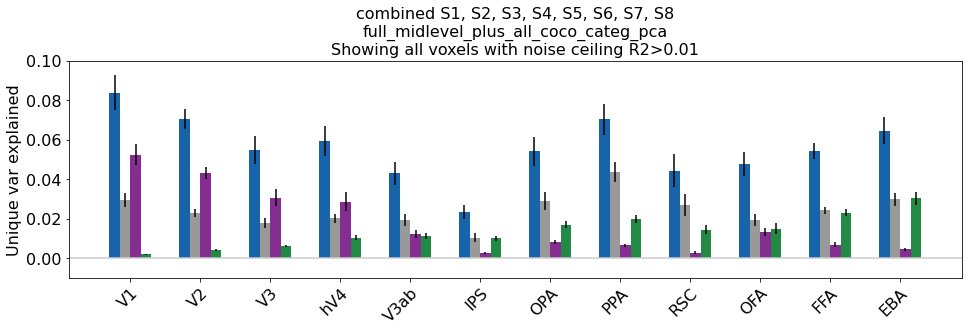

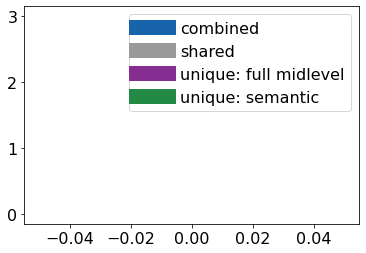

In [21]:
# Make a barplot for variance partition across all ROIs and subjects
roi_names =roi_def.roi_names
nc_thresh = 0.01

name1 = 'full midlevel'
name2 = 'semantic'

# ve_names = ['shared', 'unique: ' + name1, 'unique: ' + name2]
ve_names = ['combined', 'shared', 'unique: ' + name1, 'unique: ' + name2]

# vis_colors = cm.Purples(np.linspace(0,1,5))[1:,:]
# sem_colors = cm.Greens(np.linspace(0,1,5))[1:,:]
# vis_color = cm.Purples(np.linspace(0,1,6))[4:5,:]
vis_color = cm.BuPu(np.linspace(0,1,6))[4:5,:]
sem_color = cm.Greens(np.linspace(0,1,5))[3:4,:]
# sem_color = cm.Reds(np.linspace(0,1,5))[3:4,:]
# gray_color1 = np.array([[0.4, 0.4, 0.4, 1]])
combined_color = cm.Blues(np.linspace(0,1,6))[4:5,:]

gray_color2 = np.array([[0.6, 0.6, 0.6, 1]])


# colors = np.concatenate([gray_color1, gray_color2, vis_color, sem_color], axis=0)
colors = np.concatenate([combined_color, gray_color2, vis_color, sem_color], axis=0)

vals = np.zeros((n_subjects, n_rois, 4))

for si, ss in enumerate(subjects):
    

    r2_combined = out[si]['val_r2'][:,0]
    r2_a = out_midlevel[si]['val_r2'][:,0]
    r2_b = out_coco[si]['val_r2'][:,0]
    
    nc = nsd_utils.ncsnr_to_nc(out[si]['voxel_ncsnr'][out[si]['voxel_mask']])/100
    inds2use = nc>nc_thresh
    
    shared_ab, unique_a, unique_b = \
        stats_utils.get_shared_unique_var(r2_combined,r2_a,r2_b)
    
    # var_expl = np.array([shared_ab, unique_a, unique_b]).T
    var_expl = np.array([r2_combined, shared_ab, unique_a, unique_b]).T

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with noise ceiling R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, nc_thresh)
plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.15;
space = (1 - (bw*mean_vals.shape[1]))/2

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=space, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.10], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(16,4))
# fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, point_data=vals, \
#                      colors=colors, space=space, \
#                 xticklabels=roi_names, ylabel='Unique var explained', \
#                 ylim=[-0.01, 0.10], title=title, horizontal_line_pos=0,\
#                 legend_labels=ve_names, \
#                 legend_overlaid=True, legend_separate=False, \
#                 fig_size=(16,4))

 
# fn2save = '/user_data/mmhender/imStat/figures/variance_partition_midlevel_semantic.pdf'
# plt.savefig(fn2save)

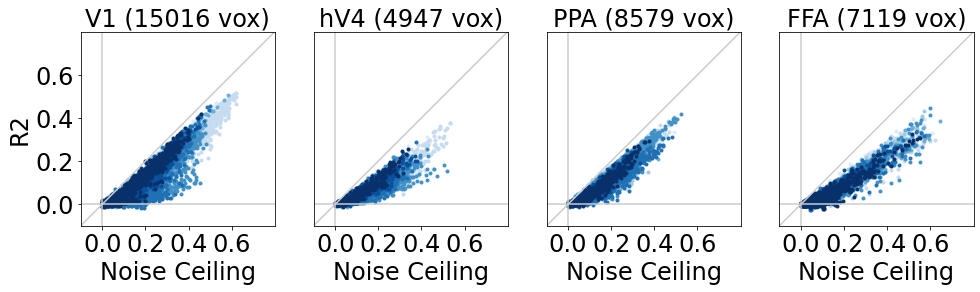

In [20]:
# Make a few scatter plots of single voxels

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

# just plot a few ROIs, because these will create very big files
rois2plot = [0, 3, 7, 10]

# concat all voxels
voxel_ncsnr = np.concatenate([o['voxel_ncsnr'][o['voxel_index']] for o in out], axis=0)
val_r2 = np.concatenate([o['val_r2'][:,0] for o in out], axis=0)

# color diff subjects differently
n_subs = len(out)
n_vox_each = np.array([o['val_r2'].shape[0] for o in out])
subject_inds = np.repeat(np.arange(n_subs), n_vox_each)

sub_colors = cm.Blues(np.linspace(0,1,n_subs+1))[1:,:]
# sub_colors[:,3] = 0.5

noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100
dat2plot = np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1)
inds2use = np.ones(np.shape(val_r2))==1
axlims = [-0.1, 0.8]
sp = plot_utils.scatter_plot(color=sub_colors, xlabel='Noise Ceiling', ylabel='R2', \
                                 xlims=axlims, ylims=axlims, \
                                 xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                 show_diagonal=True, show_axes=True);
plt.figure(figsize=(16,4))
plot_utils.set_all_font_sizes(24)
for ri, rr in enumerate(rois2plot):
    
    plt.subplot(1,4,ri+1)
    inds_this_roi = roi_def.get_indices(rr)
    data_this_roi = dat2plot[inds2use & inds_this_roi,:]
    subject_inds_this_roi = subject_inds[inds2use & inds_this_roi]

    sp.create(data_this_roi, new_fig=False, minimal_labels=False, \
                                      subject_inds=subject_inds_this_roi)
    if ri>0:
        plt.ylabel('')
        plt.yticks([])
        
    plt.title('%s (%d vox)'%(roi_names[rr], data_this_roi.shape[0]))
        
fn2save = '/user_data/mmhender/imStat/figures/combined_midlevel_semantic_r2_vs_nc.pdf'
plt.savefig(fn2save)